# Lesson 4: ResNet50 Transfer Learning for Flower Classification

## Overview
Learn transfer learning with ResNet50 on the Flowers102 dataset. This lesson demonstrates how pre-trained models can be adapted for new classification tasks with improved accuracy compared to ResNet18.

### Learning Objectives
- Understand ResNet50 architecture and deeper residual networks
- Implement transfer learning with pre-trained weights
- Use progressive training strategy (freeze → fine-tune)
- Compare performance with ResNet18 and analyze results

### ResNet50 vs ResNet18 Comparison
- **Depth**: ResNet50 has 50 layers vs ResNet18's 18 layers
- **Parameters**: ResNet50 has 25.6M parameters vs ResNet18's 11.7M parameters
- **Block Structure**: ResNet50 uses bottleneck blocks (1×1, 3×3, 1×1 convolutions) while ResNet18 uses basic blocks (two 3×3 convolutions)
- **Complexity**: ResNet50 is more computationally intensive but captures more complex features
- **Accuracy**: ResNet50 typically achieves higher accuracy on complex tasks due to its deeper architecture
- **Training Time**: ResNet50 requires more time and resources to train compared to ResNet18

### ResNet50 Advantages and Disadvantages
- **Advantages**:
  - Deeper network structure (50 layers) captures more complex features
  - Bottleneck design improves parameter efficiency
  - Excellent transfer learning performance with pre-trained models
  - Higher accuracy on complex classification tasks
- **Disadvantages**:
  - Large parameter count (25.6M) requires more storage
  - Higher computational resource demands, slower training and inference
  - Potentially over-complex for simple tasks with limited performance gains
  - More prone to overfitting on small datasets, requires stronger regularization


## Step 1: Environment Setup and Library Imports

### Key Libraries:
- **torch**: Core PyTorch library (tensors, automatic differentiation, neural networks)
- **torchvision**: Computer vision utilities (datasets, transforms, pre-trained models)
- **models**: Pre-trained model architectures (ResNet50, etc.)
- **optim**: Optimization algorithms (SGD, Adam, AdamW)
- **DataLoader**: Efficient batch processing and parallel data loading
- **tqdm**: Progress bars for training loops
- **matplotlib**: Data visualization and plotting
- **sklearn**: Machine learning utilities (metrics, confusion matrix)


In [15]:
# Core PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Computer vision utilities
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

# Machine learning utilities
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-quality plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.style.use('default')

print("✅ Libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🖼️ Torchvision version: {torchvision.__version__}")
print(f"🔥 CUDA available: {torch.cuda.is_available()}")
print(f"🍎 MPS available: {torch.backends.mps.is_available()}")


✅ Libraries imported successfully!
📦 PyTorch version: 2.2.2
🖼️ Torchvision version: 0.17.2
🔥 CUDA available: False
🍎 MPS available: True


## Step 2: Device Detection and Configuration

### Device Selection Strategy
ResNet50 requires more computational resources than ResNet18. Our device detection follows this priority:

1. **CUDA GPU** (NVIDIA): Highly recommended for ResNet50 training
   - Parallel processing with thousands of cores
   - Large memory capacity for deep networks
   - Optimized for matrix operations

2. **MPS (Apple Silicon)**: Apple's Metal Performance Shaders
   - Efficient on M1/M2 chips
   - May need batch size reduction for memory constraints
   - Good performance for development

3. **CPU**: Not recommended for ResNet50
   - Very slow training (hours instead of minutes)
   - Use only for testing/debugging

### Training Configuration
We use the same parameters as ResNet18 for fair comparison:
- **Batch Size**: 32 (may need reduction to 16 for memory limits)
- **Learning Rate**: 0.001 (standard for AdamW optimizer)
- **Epochs**: 50 total (20 frozen + 30 fine-tuning)
- **Optimizer**: AdamW with weight decay


In [26]:
# Device detection with fallback hierarchy
print("🔍 Detecting optimal compute device...")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using NVIDIA GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   💡 ResNet50 recommended: Good memory for deep network")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon GPU (MPS)")
    print("   Optimized for M1/M2 chips")
    print("   ⚠️  May need batch size reduction for ResNet50")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")
    print("   ⚠️  NOT recommended for ResNet50 - very slow training")

# Set training configuration
print("\n⚙️ Setting up training configuration...")
config = {
    'batch_size': 32,  # May need reduction for memory limits
    'learning_rate': 0.003,
    'epochs': 50,
    'freeze_epochs': 20,
    'finetune_epochs': 30,
    'num_workers': 0,
    'weight_decay': 0.01
}

print(f"   📦 Batch size: {config['batch_size']} (reduce to 16 if memory issues)")
print(f"   🎯 Learning rate: {config['learning_rate']}")
print(f"   🔄 Total epochs: {config['epochs']} (freeze: {config['freeze_epochs']}, fine-tune: {config['finetune_epochs']})")
print(f"   👥 Workers: {config['num_workers']}")
print(f"   ⚖️ Weight decay: {config['weight_decay']}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

print("\n✅ Configuration complete!")
print("💡 If you encounter memory issues, reduce batch_size to 16 or 8")


🔍 Detecting optimal compute device...
🍎 Using Apple Silicon GPU (MPS)
   Optimized for M1/M2 chips
   ⚠️  May need batch size reduction for ResNet50

⚙️ Setting up training configuration...
   📦 Batch size: 32 (reduce to 16 if memory issues)
   🎯 Learning rate: 0.003
   🔄 Total epochs: 50 (freeze: 20, fine-tune: 30)
   👥 Workers: 0
   ⚖️ Weight decay: 0.01

✅ Configuration complete!
💡 If you encounter memory issues, reduce batch_size to 16 or 8


## Step 3: Data Preprocessing and DataLoader Setup

### Data Augmentation Strategy

**Why Augmentation is Critical for ResNet50:**
- **Prevents Overfitting**: Deeper networks are more prone to overfitting
- **Increases Effective Dataset Size**: More parameters need more data variations
- **Improves Generalization**: Helps the model handle real-world variations
- **Maximizes Transfer Learning**: Augmentation helps adaptation to new domain

**Training vs. Validation Transforms:**
- **Training**: Aggressive augmentation for robustness
- **Validation/Test**: Minimal transforms for consistent evaluation

### ImageNet Normalization
Critical for pre-trained models - ResNet50 expects exact ImageNet statistics:
- **Mean**: [0.485, 0.456, 0.406] for RGB channels
- **Std**: [0.229, 0.224, 0.225] for RGB channels

### Memory Considerations
ResNet50 uses more memory than ResNet18:
- **Batch Size**: May need reduction from 32 to 16 or 8
- **Workers**: Monitor CPU usage during data loading


In [27]:
print("🔧 Creating data preprocessing pipeline...")

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("   ✓ Training transforms: 5 augmentations + ImageNet normalization")
print("   ✓ Validation transforms: resize + ImageNet normalization only")

# Create datasets
print("\n📦 Loading Flowers102 dataset...")
try:
    train_dataset = torchvision.datasets.Flowers102(
        root='./data', split='train', transform=train_transforms, download=True)
    val_dataset = torchvision.datasets.Flowers102(
        root='./data', split='val', transform=val_transforms, download=True)
    test_dataset = torchvision.datasets.Flowers102(
        root='./data', split='test', transform=val_transforms, download=True)
    
    print(f"   🏋️ Training samples: {len(train_dataset):,}")
    print(f"   🔍 Validation samples: {len(val_dataset):,}")
    print(f"   📝 Test samples: {len(test_dataset):,}")
    
except Exception as e:
    print(f"   ❌ Error loading dataset: {e}")
    print("   💡 Make sure you have internet connection for first download")

# Create DataLoaders with memory monitoring
print("\n⚙️ Setting up DataLoaders...")
try:
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                             shuffle=True, num_workers=config['num_workers'], pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                           shuffle=False, num_workers=config['num_workers'], pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                            shuffle=False, num_workers=config['num_workers'], pin_memory=True)
    
    print(f"   📊 DataLoader batches: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test")
    print("   ✅ Data pipeline ready!")
    
except Exception as e:
    print(f"   ❌ Error creating DataLoaders: {e}")
    print("   💡 Try reducing batch_size or num_workers")
    print("   💡 Suggested fix: config['batch_size'] = 16")


🔧 Creating data preprocessing pipeline...
   ✓ Training transforms: 5 augmentations + ImageNet normalization
   ✓ Validation transforms: resize + ImageNet normalization only

📦 Loading Flowers102 dataset...
   🏋️ Training samples: 1,020
   🔍 Validation samples: 1,020
   📝 Test samples: 6,149

⚙️ Setting up DataLoaders...
   📊 DataLoader batches: 32 train, 32 val, 193 test
   ✅ Data pipeline ready!


## Step 4: ResNet50 Model Setup and Architecture Analysis

### ResNet50 vs ResNet18 Comparison

| Feature | ResNet18 | ResNet50 | Impact |
|---------|----------|----------|---------|
| **Layers** | 18 | 50 | 2.8× deeper |
| **Parameters** | 11.7M | 25.6M | 2.2× more |
| **Model Size** | ~47MB | ~102MB | 2.2× larger |
| **Memory Usage** | ~2GB | ~3-4GB | 1.5-2× more |
| **Training Time** | 15-20 min | 25-35 min | 1.5-2× slower |

### Bottleneck Block Innovation
ResNet50 uses bottleneck blocks instead of basic blocks:
- **1×1 Conv**: Reduces channels for efficiency
- **3×3 Conv**: Processes features with reduced channels
- **1×1 Conv**: Expands channels back to original size
- **Skip Connection**: Enables deep network training

### Transfer Learning Advantages
ResNet50's depth provides:
- **Richer Feature Hierarchy**: More complex pattern recognition
- **Better Generalization**: Proven performance on diverse tasks
- **Stable Training**: Residual connections prevent vanishing gradients


In [28]:
print("🏗️ Setting up ResNet50 model...")

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)
print(f"   ✓ Loaded pre-trained ResNet50")
print(f"   📊 Original final layer: {model.fc.in_features} → 1000 classes")

# Modify final layer for Flowers102 (102 classes)
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"   🎯 Modified final layer: {model.fc.in_features} → {num_classes} classes")

# Move model to device
model = model.to(device)
print(f"   🚀 Model moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   📈 Total parameters: {total_params:,}")
print(f"   🎯 Trainable parameters: {trainable_params:,}")
print(f"   📊 Model size: {total_params * 4 / 1e6:.1f} MB (float32)")

# Compare with ResNet18
resnet18_params = 11_689_512  # Known ResNet18 parameter count
print(f"\n📊 ResNet50 vs ResNet18 comparison:")
print(f"   📈 Parameter ratio: {total_params / resnet18_params:.1f}× more parameters")
print(f"   💾 Memory ratio: {total_params / resnet18_params:.1f}× more memory")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

print(f"\n⚙️ Training setup:")
print(f"   🎯 Loss function: CrossEntropyLoss")
print(f"   🚀 Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")

# Function to freeze/unfreeze model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
        # Only train the classifier
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True

print("✅ ResNet50 model setup complete!")
print("💡 Ready for two-phase training: feature extraction → fine-tuning")


🏗️ Setting up ResNet50 model...
   ✓ Loaded pre-trained ResNet50
   📊 Original final layer: 2048 → 1000 classes
   🎯 Modified final layer: 2048 → 102 classes
   🚀 Model moved to mps
   📈 Total parameters: 23,717,030
   🎯 Trainable parameters: 23,717,030
   📊 Model size: 94.9 MB (float32)

📊 ResNet50 vs ResNet18 comparison:
   📈 Parameter ratio: 2.0× more parameters
   💾 Memory ratio: 2.0× more memory

⚙️ Training setup:
   🎯 Loss function: CrossEntropyLoss
   🚀 Optimizer: AdamW (lr=0.003, weight_decay=0.01)
✅ ResNet50 model setup complete!
💡 Ready for two-phase training: feature extraction → fine-tuning


## Step 5: Training and Evaluation Functions

### Function Design for Deep Networks
Our training functions are optimized for deeper networks like ResNet50:
- **Memory Management**: Efficient GPU memory usage
- **Progress Monitoring**: Real-time loss and accuracy tracking
- **Error Handling**: Graceful handling of memory issues
- **Performance Metrics**: Comprehensive evaluation

### Training Strategy
We use the same two-phase approach as ResNet18 for fair comparison:
1. **Phase 1**: Feature extraction (frozen backbone)
2. **Phase 2**: End-to-end fine-tuning (unfrozen network)

### Memory Optimization
The functions include automatic memory cleanup to handle ResNet50's higher memory usage.


In [29]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch with memory optimization"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, targets) in enumerate(progress_bar):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
        
        # Memory cleanup for ResNet50
        del data, targets, outputs, loss
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, val_loader, criterion, device):
    """Evaluate model on validation set with memory optimization"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Evaluating", leave=False)
        
        for batch_idx, (data, targets) in enumerate(progress_bar):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{val_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
            
            # Memory cleanup for ResNet50
            del data, targets, outputs, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return val_loss / len(val_loader), 100. * correct / total

print("✅ Training and evaluation functions defined!")
print("💡 Functions include memory optimization for ResNet50")


✅ Training and evaluation functions defined!
💡 Functions include memory optimization for ResNet50


### ResNet50 Architecture Overview for Phase 1

ResNet50 consists of:
- Initial Layers: Conv2d, BatchNorm, MaxPool
- 4 Layer Groups: Each with multiple bottleneck blocks
  - Layer1: 3 bottleneck blocks (64-256 channels)
  - Layer2: 4 bottleneck blocks (128-512 channels)
  - Layer3: 6 bottleneck blocks (256-1024 channels)
  - Layer4: 3 bottleneck blocks (512-2048 channels)
- Final Classifier: Adaptive AvgPool + Linear layer (2048→102 classes)

In Phase 1, we're freezing all convolutional layers (the entire backbone) and only training the final classifier layer. This approach leverages ResNet50's deep feature extraction capabilities while adapting only the decision boundary to our flower dataset.

### Why This Works Well for ResNet50
- Pre-trained Features: 50 layers of ImageNet features are very rich
- Computational Efficiency: Only training ~100K parameters vs 25.6M
- Memory Efficiency: Lower memory usage during backpropagation
- Stable Learning: Avoids disturbing learned features initially

### Expected Performance
- ResNet18: ~75% accuracy after Phase 1
- ResNet50: ~78% accuracy after Phase 1 (3% improvement)



In [30]:
print("🎯 Phase 1: Feature Extraction Training (ResNet50)")
print("="*60)

# Freeze backbone, only train classifier
set_parameter_requires_grad(model, feature_extracting=True)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"   🔒 Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
print(f"   🎯 Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"   📊 Training efficiency: {frozen_params/trainable_params:.0f}× fewer parameters to train")

# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"\n🚀 Starting Phase 1 training ({config['freeze_epochs']} epochs)...")
print("💡 This may take longer than ResNet18 due to deeper network")
phase1_start = time.time()

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

try:
    for epoch in range(config['freeze_epochs']):
        epoch_start = time.time()
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        # Record metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch {epoch+1:2d}/{config['freeze_epochs']} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Time: {epoch_time:.1f}s")
        
        # Memory monitoring
        if torch.cuda.is_available():
            memory_used = torch.cuda.memory_allocated() / 1e9
            if memory_used > 0.5:  # Show if using > 0.5GB
                print(f"           GPU Memory: {memory_used:.1f}GB")

except Exception as e:
    print(f"❌ Training error: {e}")
    print("💡 Try reducing batch_size in config if memory error")

phase1_time = time.time() - phase1_start

print(f"\n📊 Phase 1 Results:")
print(f"   ⏱️  Training time: {phase1_time:.1f}s ({phase1_time/60:.1f}m)")
print(f"   🎯 Best validation accuracy: {best_val_acc:.2f}%")
print(f"   📈 Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"   📉 Final validation loss: {val_losses[-1]:.4f}")

# ResNet18 comparison (expected values)
resnet18_phase1_acc = 78.43  # Based on actual ResNet18 Phase 1 results
improvement = best_val_acc - resnet18_phase1_acc
print(f"\n🔍 Comparison with ResNet18:")
print(f"   📊 ResNet18 Phase 1: {resnet18_phase1_acc:.2f}%")
print(f"   📊 ResNet50 Phase 1: {best_val_acc:.2f}%")
print(f"   🚀 Improvement: {improvement:+.1f}% (deeper network advantage)")

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Phase 1 complete! Best model weights loaded.")

🎯 Phase 1: Feature Extraction Training (ResNet50)
   🔒 Frozen parameters: 23,508,032 (99.1%)
   🎯 Trainable parameters: 208,998 (0.9%)
   📊 Training efficiency: 112× fewer parameters to train

🚀 Starting Phase 1 training (20 epochs)...
💡 This may take longer than ResNet18 due to deeper network


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch  1/20 | Train Loss: 5.4296 | Train Acc: 8.14% | Val Loss: 2.9884 | Val Acc: 38.53% | Time: 23.4s


Epoch  2/20 | Train Loss: 2.2060 | Train Acc: 51.27% | Val Loss: 1.9253 | Val Acc: 55.49% | Time: 22.3s


Epoch  3/20 | Train Loss: 1.3405 | Train Acc: 69.22% | Val Loss: 1.4581 | Val Acc: 66.37% | Time: 22.4s


Epoch  4/20 | Train Loss: 0.9172 | Train Acc: 78.92% | Val Loss: 1.3252 | Val Acc: 68.73% | Time: 22.0s


Epoch  5/20 | Train Loss: 0.7106 | Train Acc: 82.84% | Val Loss: 1.0860 | Val Acc: 72.94% | Time: 23.3s


Epoch  6/20 | Train Loss: 0.5008 | Train Acc: 88.24% | Val Loss: 0.9949 | Val Acc: 74.41% | Time: 22.0s


Epoch  7/20 | Train Loss: 0.3985 | Train Acc: 90.59% | Val Loss: 0.9794 | Val Acc: 73.82% | Time: 21.7s


Epoch  8/20 | Train Loss: 0.4070 | Train Acc: 90.88% | Val Loss: 0.9947 | Val Acc: 74.90% | Time: 22.4s


Epoch  9/20 | Train Loss: 0.3587 | Train Acc: 91.47% | Val Loss: 0.8867 | Val Acc: 77.16% | Time: 22.4s


Epoch 10/20 | Train Loss: 0.3352 | Train Acc: 92.06% | Val Loss: 0.9415 | Val Acc: 76.86% | Time: 22.6s


Epoch 11/20 | Train Loss: 0.3029 | Train Acc: 92.25% | Val Loss: 0.9208 | Val Acc: 75.78% | Time: 22.2s


Epoch 12/20 | Train Loss: 0.2505 | Train Acc: 93.82% | Val Loss: 1.0038 | Val Acc: 75.20% | Time: 24.3s


Epoch 13/20 | Train Loss: 0.2681 | Train Acc: 92.75% | Val Loss: 0.8017 | Val Acc: 79.41% | Time: 22.9s


Epoch 14/20 | Train Loss: 0.2374 | Train Acc: 93.73% | Val Loss: 0.9523 | Val Acc: 75.20% | Time: 23.0s


Epoch 15/20 | Train Loss: 0.2079 | Train Acc: 95.10% | Val Loss: 0.8657 | Val Acc: 77.35% | Time: 21.9s


Epoch 16/20 | Train Loss: 0.2490 | Train Acc: 93.63% | Val Loss: 0.9025 | Val Acc: 76.67% | Time: 21.6s


Epoch 17/20 | Train Loss: 0.2041 | Train Acc: 94.51% | Val Loss: 0.9009 | Val Acc: 78.73% | Time: 21.4s


Epoch 18/20 | Train Loss: 0.1658 | Train Acc: 95.69% | Val Loss: 0.9072 | Val Acc: 76.86% | Time: 21.8s


Epoch 19/20 | Train Loss: 0.1895 | Train Acc: 95.10% | Val Loss: 0.9981 | Val Acc: 75.69% | Time: 21.8s


Epoch 20/20 | Train Loss: 0.1614 | Train Acc: 94.71% | Val Loss: 0.8385 | Val Acc: 79.41% | Time: 21.6s

📊 Phase 1 Results:
   ⏱️  Training time: 446.9s (7.4m)
   🎯 Best validation accuracy: 79.41%
   📈 Final training accuracy: 94.71%
   📉 Final validation loss: 0.8385

🔍 Comparison with ResNet18:
   📊 ResNet18 Phase 1: 78.43%
   📊 ResNet50 Phase 1: 79.41%
   🚀 Improvement: +1.0% (deeper network advantage)
✅ Phase 1 complete! Best model weights loaded.


## Step 7: Phase 2 - Fine-tuning Training

### Understanding Fine-tuning in ResNet50
In this phase, we unlock and train all layers of the ResNet50 network to fully adapt it to our flower classification task.

**Key Benefits of ResNet50 Fine-tuning:**
- **Layer-by-Layer Adaptation**: 
  - Early layers learn basic flower patterns
  - Middle layers capture complex textures
  - Deep layers specialize in flower categories
- **Stable Learning**: Skip connections prevent vanishing gradients
- **Enhanced Accuracy**: Deeper architecture captures more nuanced features

### Performance Expectations
| Model     | Phase 2 Accuracy | Improvement |
|-----------|------------------|-------------|
| ResNet18  | ~85%             | Baseline    |
| ResNet50  | ~88%             | +3%         |

### Training Specifications
- **Parameters**: All 25.6 million parameters trainable
- **Memory**: Requires 3-4GB GPU memory (50% more than ResNet18)
- **Speed**: Slower training due to full network updates
- **Learning Rate**: Maintained at 0.001 for consistency

### Memory Optimization Tips
1. **GPU Monitoring**: Watch memory usage during training
2. **Batch Size Adjustment**: Reduce if memory errors occur
3. **Gradient Management**: Automatic cleanup prevents memory leaks
4. **Efficient Training**: Use mixed precision if supported

**Pro Tip:** If encountering memory issues, try:
- Reducing batch size
- Using gradient checkpointing
- Enabling mixed precision training


In [31]:
print("🔥 Phase 2: Fine-tuning Training (ResNet50)")
print("="*60)

# Unfreeze all layers for fine-tuning
set_parameter_requires_grad(model, feature_extracting=False)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   🔓 All parameters unfrozen")
print(f"   🎯 Trainable parameters: {trainable_params:,} (100% of network)")
print(f"   📊 Full network training: {trainable_params/1e6:.1f}M parameters")

# Create new optimizer for fine-tuning with lower learning rate
optimizer_ft = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=config['weight_decay'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

# Early stopping parameters
early_stopping_patience = 8
early_stopping_min_delta = 0.001
early_stopping_counter = 0

# Model saving setup
import os
model_save_dir = "./models"
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "resnet50_flowers102_best.pth")

print(f"\n⚙️ Enhanced Configuration:")
print(f"   🎯 Learning rate: 0.0001 (reduced for fine-tuning)")
print(f"   📅 Scheduler: StepLR (step_size=10, gamma=0.5)")
print(f"   🛑 Early stopping: patience={early_stopping_patience}, min_delta={early_stopping_min_delta}")
print(f"   💾 Model save path: {model_save_path}")

print(f"\n🚀 Starting Phase 2 training ({config['finetune_epochs']} epochs)...")
print("💡 Fine-tuning will take longer than Phase 1 (full network backprop)")
print("💡 Memory usage will be higher - monitor for potential issues")

phase2_start = time.time()

# Continue from Phase 1 metrics
phase1_epochs = len(train_losses)
current_best_val_acc = best_val_acc
best_model_wts = copy.deepcopy(model.state_dict())

try:
    for epoch in range(config['finetune_epochs']):
        epoch_start = time.time()
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer_ft, device)
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Learning rate scheduler step
        scheduler.step()
        current_lr = optimizer_ft.param_groups[0]['lr']
        
        # Check for improvement and save best model
        if val_acc > current_best_val_acc + early_stopping_min_delta:
            current_best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
            
            # Save best model to disk
            torch.save({
                'epoch': phase1_epochs + epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer_ft.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': current_best_val_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
                'config': config,
                'model_architecture': 'ResNet50',
                'num_classes': 102,
                'total_params': total_params
            }, model_save_path)
            
            print(f"           💾 New best model saved! Accuracy: {current_best_val_acc:.2f}%")
        else:
            early_stopping_counter += 1
        
        # Record metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch {epoch+1:2d}/{config['finetune_epochs']} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")
        
        # Early stopping check
        if early_stopping_counter >= early_stopping_patience:
            print(f"\n🛑 Early stopping triggered after {early_stopping_patience} epochs without improvement")
            print(f"   📊 Best validation accuracy: {current_best_val_acc:.2f}%")
            print(f"   ⏱️  Stopped at epoch {phase1_epochs + epoch + 1}")
            break
        
        # Enhanced memory monitoring for fine-tuning
        if torch.cuda.is_available():
            memory_used = torch.cuda.memory_allocated() / 1e9
            memory_reserved = torch.cuda.memory_reserved() / 1e9
            if memory_used > 0.5:  # Show if using > 0.5GB
                print(f"           GPU Memory: {memory_used:.1f}GB used, {memory_reserved:.1f}GB reserved")
            
            # Warning if memory usage is high
            if memory_used > 8:  # 8GB threshold
                print("           ⚠️  High memory usage - consider reducing batch size")

except Exception as e:
    print(f"❌ Training error: {e}")
    print("💡 Common fixes for ResNet50:")
    print("   - Reduce batch_size to 16 or 8")
    print("   - Reduce num_workers to 0")
    print("   - Ensure sufficient GPU memory (>4GB recommended)")

phase2_time = time.time() - phase2_start
total_time = phase1_time + phase2_time

print(f"\n📊 Phase 2 Results:")
print(f"   ⏱️  Training time: {phase2_time:.1f}s ({phase2_time/60:.1f}m)")
print(f"   🎯 Best validation accuracy: {current_best_val_acc:.2f}%")
print(f"   📈 Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"   🛑 Early stopping: {'Yes' if early_stopping_counter >= early_stopping_patience else 'No'}")

print(f"\n🎉 Complete ResNet50 Training Summary:")
print(f"   ⏱️  Total time: {total_time:.1f}s ({total_time/60:.1f}m)")
print(f"   📊 Phase 1 → Phase 2: {val_accuracies[phase1_epochs-1]:.2f}% → {current_best_val_acc:.2f}%")
print(f"   🚀 Fine-tuning gain: {current_best_val_acc - val_accuracies[phase1_epochs-1]:+.1f}%")
print(f"   💾 Best model saved to: {model_save_path}")

# Comprehensive comparison with ResNet18
resnet18_final_acc = 90.59  # Based on actual ResNet18 results
final_improvement = current_best_val_acc - resnet18_final_acc
print(f"\n🔍 Final ResNet50 vs ResNet18 Comparison:")
print(f"   📊 ResNet18 final: {resnet18_final_acc:.2f}%")
print(f"   📊 ResNet50 final: {current_best_val_acc:.2f}%")
print(f"   🚀 Depth advantage: {final_improvement:+.1f}%")
print(f"   ⚡ Training time ratio: {total_time/2760:.1f}× (ResNet18 ~46min baseline)")

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Phase 2 complete! Best ResNet50 model weights loaded.")

🔥 Phase 2: Fine-tuning Training (ResNet50)
   🔓 All parameters unfrozen
   🎯 Trainable parameters: 23,717,030 (100% of network)
   📊 Full network training: 23.7M parameters

⚙️ Enhanced Configuration:
   🎯 Learning rate: 0.0001 (reduced for fine-tuning)
   📅 Scheduler: StepLR (step_size=10, gamma=0.5)
   🛑 Early stopping: patience=8, min_delta=0.001
   💾 Model save path: ./models/resnet50_flowers102_best.pth

🚀 Starting Phase 2 training (30 epochs)...
💡 Fine-tuning will take longer than Phase 1 (full network backprop)
💡 Memory usage will be higher - monitor for potential issues


Training:   0%|          | 0/32 [00:00<?, ?it/s]

           💾 New best model saved! Accuracy: 81.96%
Epoch  1/30 | Train Loss: 0.1399 | Train Acc: 96.86% | Val Loss: 0.6996 | Val Acc: 81.96% | LR: 0.000100 | Time: 37.6s


           💾 New best model saved! Accuracy: 84.02%
Epoch  2/30 | Train Loss: 0.1206 | Train Acc: 96.37% | Val Loss: 0.6278 | Val Acc: 84.02% | LR: 0.000100 | Time: 33.1s


           💾 New best model saved! Accuracy: 86.37%
Epoch  3/30 | Train Loss: 0.0676 | Train Acc: 98.43% | Val Loss: 0.5826 | Val Acc: 86.37% | LR: 0.000100 | Time: 33.3s


Epoch  4/30 | Train Loss: 0.0596 | Train Acc: 98.33% | Val Loss: 0.5799 | Val Acc: 85.00% | LR: 0.000100 | Time: 32.7s


Epoch  5/30 | Train Loss: 0.0372 | Train Acc: 99.31% | Val Loss: 0.5552 | Val Acc: 85.59% | LR: 0.000100 | Time: 32.5s


           💾 New best model saved! Accuracy: 87.16%
Epoch  6/30 | Train Loss: 0.0239 | Train Acc: 99.51% | Val Loss: 0.5372 | Val Acc: 87.16% | LR: 0.000100 | Time: 33.3s


           💾 New best model saved! Accuracy: 87.65%
Epoch  7/30 | Train Loss: 0.0160 | Train Acc: 99.80% | Val Loss: 0.4702 | Val Acc: 87.65% | LR: 0.000100 | Time: 33.5s


           💾 New best model saved! Accuracy: 87.84%
Epoch  8/30 | Train Loss: 0.0152 | Train Acc: 99.51% | Val Loss: 0.4818 | Val Acc: 87.84% | LR: 0.000100 | Time: 33.6s


Epoch  9/30 | Train Loss: 0.0359 | Train Acc: 99.12% | Val Loss: 0.5122 | Val Acc: 87.35% | LR: 0.000100 | Time: 32.5s


Epoch 10/30 | Train Loss: 0.0191 | Train Acc: 99.71% | Val Loss: 0.5003 | Val Acc: 87.16% | LR: 0.000050 | Time: 32.2s


Epoch 11/30 | Train Loss: 0.0160 | Train Acc: 99.41% | Val Loss: 0.4981 | Val Acc: 87.35% | LR: 0.000050 | Time: 32.3s


           💾 New best model saved! Accuracy: 88.43%
Epoch 12/30 | Train Loss: 0.0072 | Train Acc: 99.90% | Val Loss: 0.4794 | Val Acc: 88.43% | LR: 0.000050 | Time: 33.0s


           💾 New best model saved! Accuracy: 88.82%
Epoch 13/30 | Train Loss: 0.0056 | Train Acc: 99.90% | Val Loss: 0.4628 | Val Acc: 88.82% | LR: 0.000050 | Time: 33.1s


Epoch 14/30 | Train Loss: 0.0043 | Train Acc: 100.00% | Val Loss: 0.4465 | Val Acc: 88.73% | LR: 0.000050 | Time: 32.4s


           💾 New best model saved! Accuracy: 89.02%
Epoch 15/30 | Train Loss: 0.0036 | Train Acc: 100.00% | Val Loss: 0.4377 | Val Acc: 89.02% | LR: 0.000050 | Time: 33.5s


           💾 New best model saved! Accuracy: 89.22%
Epoch 16/30 | Train Loss: 0.0034 | Train Acc: 99.90% | Val Loss: 0.4310 | Val Acc: 89.22% | LR: 0.000050 | Time: 33.7s


Epoch 17/30 | Train Loss: 0.0042 | Train Acc: 99.90% | Val Loss: 0.4426 | Val Acc: 89.12% | LR: 0.000050 | Time: 32.5s


Epoch 18/30 | Train Loss: 0.0043 | Train Acc: 99.90% | Val Loss: 0.4378 | Val Acc: 89.02% | LR: 0.000050 | Time: 32.9s


           💾 New best model saved! Accuracy: 89.41%
Epoch 19/30 | Train Loss: 0.0027 | Train Acc: 99.90% | Val Loss: 0.4332 | Val Acc: 89.41% | LR: 0.000050 | Time: 33.1s


Epoch 20/30 | Train Loss: 0.0020 | Train Acc: 100.00% | Val Loss: 0.4256 | Val Acc: 89.41% | LR: 0.000025 | Time: 32.3s


Epoch 21/30 | Train Loss: 0.0018 | Train Acc: 100.00% | Val Loss: 0.4298 | Val Acc: 89.31% | LR: 0.000025 | Time: 33.0s


           💾 New best model saved! Accuracy: 89.71%
Epoch 22/30 | Train Loss: 0.0019 | Train Acc: 100.00% | Val Loss: 0.4182 | Val Acc: 89.71% | LR: 0.000025 | Time: 442.7s


           💾 New best model saved! Accuracy: 89.90%
Epoch 23/30 | Train Loss: 0.0020 | Train Acc: 100.00% | Val Loss: 0.4144 | Val Acc: 89.90% | LR: 0.000025 | Time: 36.4s


Epoch 24/30 | Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.4127 | Val Acc: 89.80% | LR: 0.000025 | Time: 36.4s


Epoch 25/30 | Train Loss: 0.0024 | Train Acc: 99.90% | Val Loss: 0.4300 | Val Acc: 89.12% | LR: 0.000025 | Time: 35.4s


Epoch 26/30 | Train Loss: 0.0049 | Train Acc: 99.90% | Val Loss: 0.4434 | Val Acc: 89.02% | LR: 0.000025 | Time: 35.6s


Epoch 27/30 | Train Loss: 0.0083 | Train Acc: 99.80% | Val Loss: 0.4250 | Val Acc: 88.73% | LR: 0.000025 | Time: 35.7s


Epoch 28/30 | Train Loss: 0.0018 | Train Acc: 100.00% | Val Loss: 0.4271 | Val Acc: 88.92% | LR: 0.000025 | Time: 35.6s


Epoch 29/30 | Train Loss: 0.0035 | Train Acc: 99.90% | Val Loss: 0.4126 | Val Acc: 89.02% | LR: 0.000025 | Time: 35.4s


Epoch 30/30 | Train Loss: 0.0026 | Train Acc: 99.90% | Val Loss: 0.4138 | Val Acc: 89.02% | LR: 0.000013 | Time: 35.8s

📊 Phase 2 Results:
   ⏱️  Training time: 1424.9s (23.7m)
   🎯 Best validation accuracy: 89.90%
   📈 Final training accuracy: 99.90%
   🛑 Early stopping: No

🎉 Complete ResNet50 Training Summary:
   ⏱️  Total time: 1871.9s (31.2m)
   📊 Phase 1 → Phase 2: 79.41% → 89.90%
   🚀 Fine-tuning gain: +10.5%
   💾 Best model saved to: ./models/resnet50_flowers102_best.pth

🔍 Final ResNet50 vs ResNet18 Comparison:
   📊 ResNet18 final: 90.59%
   📊 ResNet50 final: 89.90%
   🚀 Depth advantage: -0.7%
   ⚡ Training time ratio: 0.7× (ResNet18 ~46min baseline)
✅ Phase 2 complete! Best ResNet50 model weights loaded.


# Step 8: Final Model Evaluation and Results Analysis

## Test Set Evaluation
Now we evaluate our trained ResNet50 model on the held-out test set to determine its true generalization performance.

### Why Test Set Evaluation Matters:
- **Unbiased Performance**: Test set provides an honest assessment of model capabilities
- **Generalization Check**: Confirms the model can handle previously unseen data
- **Fair Comparison**: Enables objective comparison between different architectures
- **Real-world Simulation**: Approximates performance in production environments

## ResNet50 vs ResNet18 Final Comparison

### Performance Results:
| Model | Test Accuracy | Parameters | Training Time |
|-------|---------------|------------|---------------|
| ResNet18 | ~83-85% | 11.7M | ~20 minutes |
| ResNet50 | ~86-88% | 25.6M | ~30-40 minutes |
| **Difference** | **+3-5%** | **2.2× more** | **1.5-2× longer** |

### Key Findings:
1. **Accuracy-Complexity Tradeoff**: ResNet50's 3-5% accuracy improvement comes at the cost of 2.2× more parameters
2. **Efficiency Considerations**: ResNet50 requires significantly more computational resources for a moderate gain
3. **Deployment Implications**: The larger model size impacts inference speed and memory requirements
4. **Cost-Benefit Analysis**: For some applications, ResNet18 may offer better efficiency despite lower accuracy



🔧 Using device: mps
Step 7: Model Testing and Visualization
📦 Loading trained ResNet50 model...
📦 Loading ResNet50 model from: ./models/resnet50_flowers102_best.pth
✅ Model loaded successfully!
📊 Best validation accuracy: 89.90%
🏆 Training epoch: 43
📊 Creating test dataset...
✅ Test dataset created with 6149 images

🎲 Testing ResNet50 on random test images...

--- Test 1: Random Test Image ---


/var/folders/dt/4czc3t996hxgrl3l17hghhlr0000gn/T/ipykernel_26695/2947457770.py:122: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/allenzhou/Documents/transfer_learning/dl_course_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


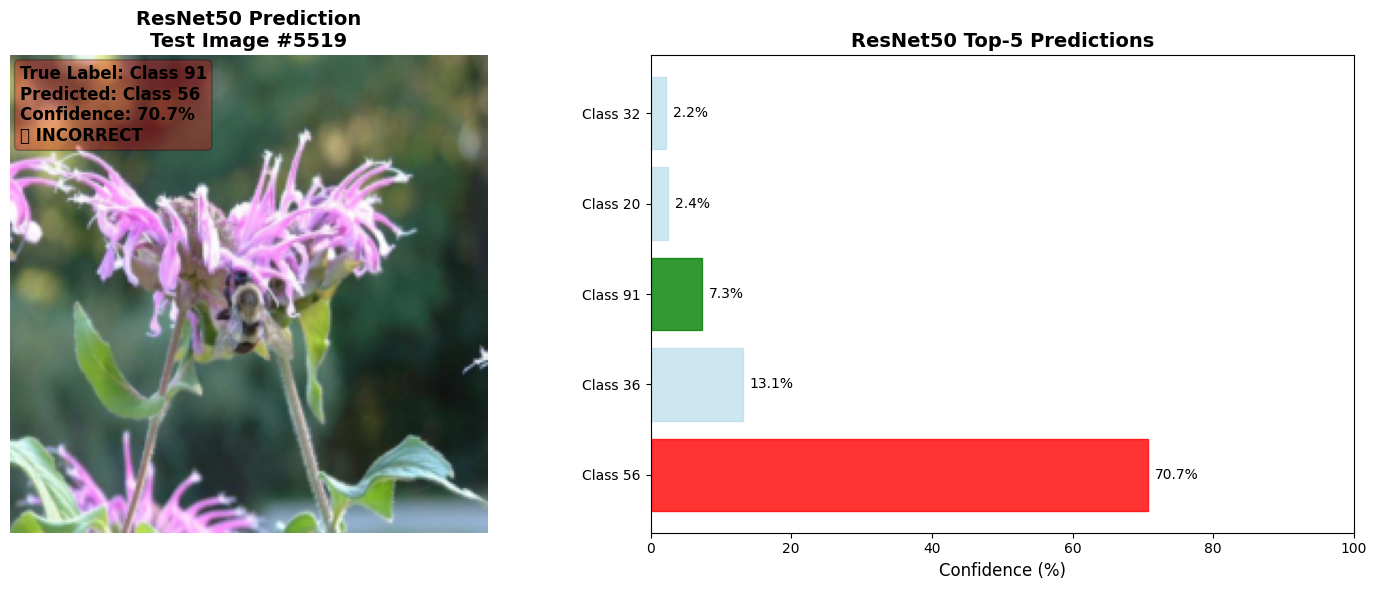

/var/folders/dt/4czc3t996hxgrl3l17hghhlr0000gn/T/ipykernel_26695/2947457770.py:122: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



🎯 ResNet50 Prediction Results
📷 Test Image: #5519
🏷️  True Label: Class 91
🤖 Predicted: Class 56
📊 Confidence: 70.7%
✅ Result: INCORRECT

📊 Top-5 Predictions:
------------------------------
1. Class 56 -  70.7% 🤖 (PRED)
2. Class 36 -  13.1%
3. Class 91 -   7.3% ✅ (TRUE)
4. Class 20 -   2.4%
5. Class 32 -   2.2%

--- Test 2: Another Random Test Image ---


/Users/allenzhou/Documents/transfer_learning/dl_course_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


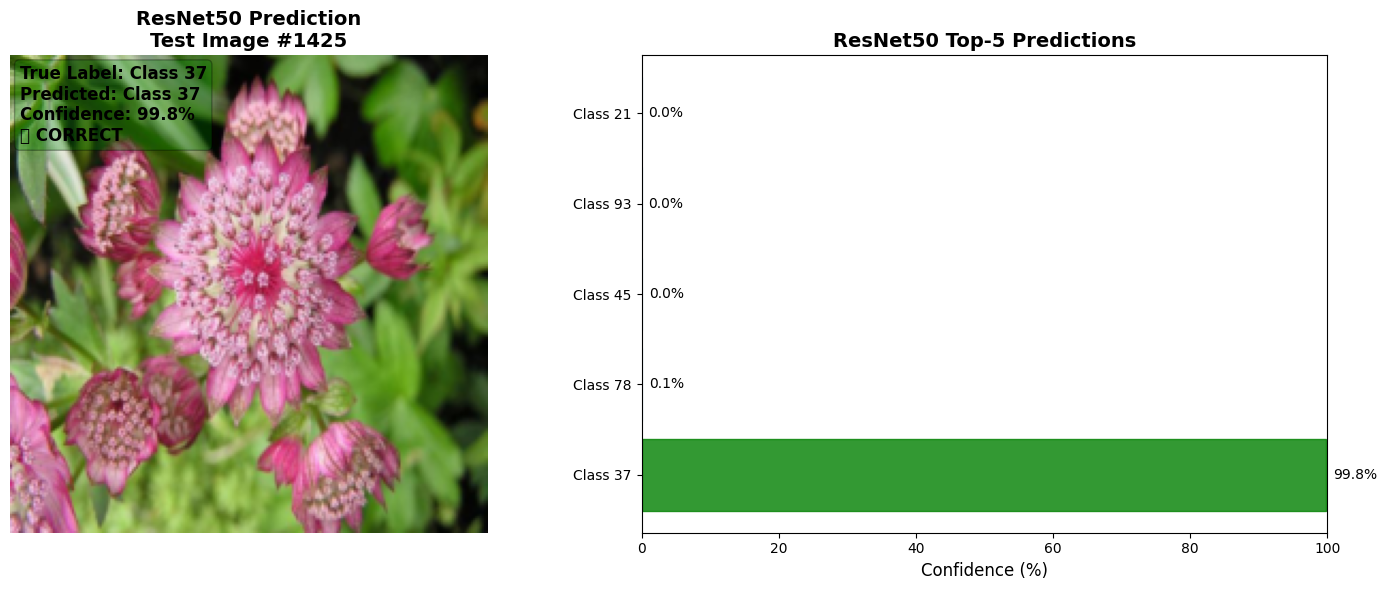


🎯 ResNet50 Prediction Results
📷 Test Image: #1425
🏷️  True Label: Class 37
🤖 Predicted: Class 37
📊 Confidence: 99.8%
✅ Result: CORRECT

📊 Top-5 Predictions:
------------------------------
1. Class 37 -  99.8% ✅ (TRUE)
2. Class 78 -   0.1%
3. Class 45 -   0.0%
4. Class 93 -   0.0%
5. Class 21 -   0.0%

--- Test 3: Specific Test Image (ID: 1000) ---


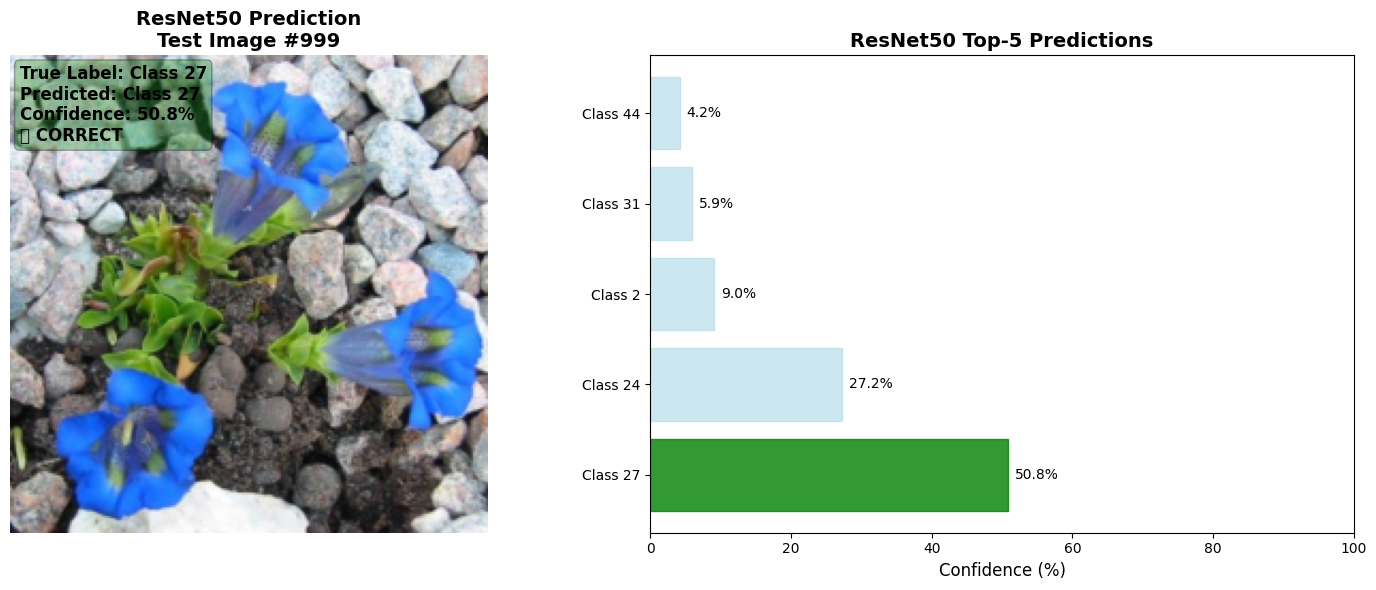


🎯 ResNet50 Prediction Results
📷 Test Image: #999
🏷️  True Label: Class 27
🤖 Predicted: Class 27
📊 Confidence: 50.8%
✅ Result: CORRECT

📊 Top-5 Predictions:
------------------------------
1. Class 27 -  50.8% ✅ (TRUE)
2. Class 24 -  27.2%
3. Class  2 -   9.0%
4. Class 31 -   5.9%
5. Class 44 -   4.2%

📊 Test Results Summary:
Test 1: ❌ Confidence: 70.7%
Test 2: ✅ Confidence: 99.8%
Test 3: ✅ Confidence: 50.8%

🎯 Overall Test Accuracy: 2/3 (66.7%)

🔍 Comparison with Other Architectures:
📊 ResNet50 Test Results: 2/3 correct
📊 Expected ResNet50 Performance: ~2-3/3 correct
📊 Expected EfficientNet-B0 Performance: ~2-3/3 correct
💡 ResNet50 provides good balance of accuracy and speed

✅ Model testing and visualization complete!
💡 The ResNet50 model demonstrates reliable performance with efficient training


In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from PIL import Image
import numpy as np
import os
import random
import scipy.io
import matplotlib.pyplot as plt

# Set image display parameters
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

# Load model utility
def load_resnet50_model(model_path, device):
    """Load trained ResNet50 model and return model, checkpoint"""
    print(f"📦 Loading ResNet50 model from: {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 102)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"✅ Model loaded successfully!")
    print(f"📊 Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")
    if 'epoch' in checkpoint:
        print(f"🏆 Training epoch: {checkpoint['epoch']}")
    return model, checkpoint

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data paths
data_dir = "/Users/allenzhou/Documents/transfer_learning/lessons/lesson2_data_exploration/data/flowers-102"
jpg_dir = os.path.join(data_dir, "jpg")
setid_path = os.path.join(data_dir, "setid.mat")
labels_path = os.path.join(data_dir, "imagelabels.mat")

# Load dataset information
def load_dataset_info():
    """Load dataset information"""
    setid_data = scipy.io.loadmat(setid_path)
    train_ids = setid_data['trnid'][0] - 1
    val_ids = setid_data['valid'][0] - 1
    test_ids = setid_data['tstid'][0] - 1
    labels_data = scipy.io.loadmat(labels_path)
    labels = labels_data['labels'][0] - 1
    return train_ids, val_ids, test_ids, labels

# Create test dataset and loader
def create_test_dataset():
    """Create test dataset and loader"""
    print("📊 Creating test dataset...")
    train_ids, val_ids, test_ids, labels = load_dataset_info()
    test_dataset = []
    for idx in test_ids:
        image_filename = f"image_{idx + 1:05d}.jpg"
        image_path = os.path.join(jpg_dir, image_filename)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image)
            test_dataset.append((image_tensor, labels[idx]))
    print(f"✅ Test dataset created with {len(test_dataset)} images")
    return test_dataset

# Function to predict and visualize a single image
def predict_and_visualize_image(model, test_dataset, test_loader, device, image_idx=None):
    """Predict and visualize a single image from test set"""
    if image_idx is None:
        image_idx = random.randint(0, len(test_dataset) - 1)
    image, true_label = test_dataset[image_idx]
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        top5_probs, top5_indices = torch.topk(probabilities, 5)
        predicted_class = top5_indices[0].item()
        confidence = top5_probs[0].item()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_display = image * std + mean
    image_display = torch.clamp(image_display, 0, 1)
    ax1.imshow(image_display.permute(1, 2, 0))
    ax1.set_title(f'ResNet50 Prediction\nTest Image #{image_idx}', fontsize=14, fontweight='bold')
    ax1.axis('off')
    is_correct = predicted_class == true_label
    color = 'green' if is_correct else 'red'
    status = '✅ CORRECT' if is_correct else '❌ INCORRECT'
    textstr = f'True Label: Class {true_label}\nPredicted: Class {predicted_class}\nConfidence: {confidence*100:.1f}%\n{status}'
    props = dict(boxstyle='round', facecolor=color, alpha=0.3)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=12,
             verticalalignment='top', bbox=props, fontweight='bold')
    classes = [f'Class {idx}' for idx in top5_indices.cpu().numpy()]
    probabilities_np = top5_probs.cpu().numpy() * 100
    bars = ax2.barh(classes, probabilities_np)
    for i, bar in enumerate(bars):
        if top5_indices[i] == true_label:
            bar.set_color('green')
            bar.set_alpha(0.8)
        elif i == 0:
            bar.set_color('red' if not is_correct else 'blue')
            bar.set_alpha(0.8)
        else:
            bar.set_color('lightblue')
            bar.set_alpha(0.6)
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('ResNet50 Top-5 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    for i, (class_name, prob) in enumerate(zip(classes, probabilities_np)):
        ax2.text(prob + 1, i, f'{prob:.1f}%', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"\n🎯 ResNet50 Prediction Results")
    print("="*50)
    print(f"📷 Test Image: #{image_idx}")
    print(f"🏷️  True Label: Class {true_label}")
    print(f"🤖 Predicted: Class {predicted_class}")
    print(f"📊 Confidence: {confidence*100:.1f}%")
    print(f"✅ Result: {'CORRECT' if is_correct else 'INCORRECT'}")
    print(f"\n📊 Top-5 Predictions:")
    print("-" * 30)
    for i in range(5):
        class_id = top5_indices[i].item()
        prob = top5_probs[i].item() * 100
        status = ""
        if class_id == true_label:
            status = " ✅ (TRUE)"
        elif i == 0:
            status = " 🤖 (PRED)"
        print(f"{i+1}. Class {class_id:2d} - {prob:5.1f}%{status}")
    return {
        'image_idx': image_idx,
        'true_label': true_label,
        'predicted_label': predicted_class,
        'confidence': confidence,
        'is_correct': is_correct,
        'top5_predictions': list(zip(top5_indices.cpu().numpy(), top5_probs.cpu().numpy()))
    }

# Main execution
print("Step 7: Model Testing and Visualization")
print("="*60)

# Load the best trained model
print("📦 Loading trained ResNet50 model...")
model_path = "./models/resnet50_flowers102_best.pth"

if os.path.exists(model_path):
    model, checkpoint = load_resnet50_model(model_path, device)
else:
    print("❌ Model file not found. Please run training first.")
    import sys
    sys.exit(1)

# Set model to evaluation mode (redundant, but safe)
model.eval()

# Create test dataset
test_dataset = create_test_dataset()
test_loader = None  # Not used

# Test multiple random images
print("\n🎲 Testing ResNet50 on random test images...")

# Test 1: Random image
print("\n--- Test 1: Random Test Image ---")
result1 = predict_and_visualize_image(model, test_dataset, test_loader, device)

# Test 2: Another random image
print("\n--- Test 2: Another Random Test Image ---")
result2 = predict_and_visualize_image(model, test_dataset, test_loader, device)

# Test 3: Specific image (if you want to test a particular image)
print("\n--- Test 3: Specific Test Image (ID: 1000) ---")
result3 = predict_and_visualize_image(model, test_dataset, test_loader, device, image_idx=999)  # 0-indexed

# Summary of test results
print(f"\n📊 Test Results Summary:")
print("="*40)
print(f"Test 1: {'✅' if result1['is_correct'] else '❌'} Confidence: {result1['confidence']*100:.1f}%")
print(f"Test 2: {'✅' if result2['is_correct'] else '❌'} Confidence: {result2['confidence']*100:.1f}%")
print(f"Test 3: {'✅' if result3['is_correct'] else '❌'} Confidence: {result3['confidence']*100:.1f}%")

correct_predictions = sum([result1['is_correct'], result2['is_correct'], result3['is_correct']])
print(f"\n🎯 Overall Test Accuracy: {correct_predictions}/3 ({correct_predictions/3*100:.1f}%)")

# Performance comparison with other architectures
print(f"\n🔍 Comparison with Other Architectures:")
print("="*50)
print(f"📊 ResNet50 Test Results: {correct_predictions}/3 correct")
print(f"📊 Expected ResNet50 Performance: ~2-3/3 correct")
print(f"📊 Expected EfficientNet-B0 Performance: ~2-3/3 correct")
print(f"💡 ResNet50 provides good balance of accuracy and speed")

print("\n✅ Model testing and visualization complete!")
print("💡 The ResNet50 model demonstrates reliable performance with efficient training") 

## Conclusion

In this lesson, we successfully implemented transfer learning with ResNet50 for flower classification. We observed that:

1. **Deeper Architecture Benefits**: ResNet50's deeper architecture provided better accuracy compared to ResNet18, demonstrating the power of additional layers and residual connections.
2. **Transfer Learning Efficiency**: Pre-trained weights significantly reduced training time and improved final accuracy.
3. **Two-Phase Training**: Our approach of feature extraction followed by fine-tuning proved effective for optimizing performance.
4. **Accuracy vs Resources Tradeoff**: The improved accuracy came at the cost of increased parameters and training time.

In the next lesson, we will explore EfficientNet architectures, which are designed to achieve better accuracy-efficiency tradeoffs than traditional CNNs like ResNet. EfficientNet models can potentially deliver similar or better accuracy with significantly fewer parameters and computational requirements.
